# Loading Libraries

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas

#pd.options.plotting.backend = 'holoviews'

# Loading data

In [24]:
bikes_df      = pd.read_excel("../00_data/bike_sales/data_raw/bikes.xlsx")
bikeshops_df  = pd.read_excel("../00_data/bike_sales/data_raw/bikeshops.xlsx")
orderlines_df = pd.read_excel("../00_data/bike_sales/data_raw/orderlines.xlsx").drop('Unnamed: 0', axis=1)

# Examining Data

In [25]:
bikes_df.head()

bike.id                           model                 description  price
0        1         Supersix Evo Black Inc.  Road - Elite Road - Carbon  12790
1        2        Supersix Evo Hi-Mod Team  Road - Elite Road - Carbon  10660
2        3  Supersix Evo Hi-Mod Dura Ace 1  Road - Elite Road - Carbon   7990
3        4  Supersix Evo Hi-Mod Dura Ace 2  Road - Elite Road - Carbon   5330
4        5      Supersix Evo Hi-Mod Utegra  Road - Elite Road - Carbon   4260

In [26]:
bikeshops_df.head()

bikeshop.id                 bikeshop.name        location
0            1  Pittsburgh Mountain Machines  Pittsburgh, PA
1            2      Ithaca Mountain Climbers      Ithaca, NY
2            3       Columbus Race Equipment    Columbus, OH
3            4                Detroit Cycles     Detroit, MI
4            5              Cincinnati Speed  Cincinnati, OH

In [27]:
orderlines_df.head()

order.id  order.line order.date  customer.id  product.id  quantity
0         1           1 2011-01-07            2          48         1
1         1           2 2011-01-07            2          52         1
2         2           1 2011-01-10           10          76         1
3         2           2 2011-01-10           10          52         1
4         3           1 2011-01-10            6           2         1

# Joining Data

In [85]:
bike_orderlines_joined_df = (
    orderlines_df
    .merge(bikes_df, how='left', left_on="product.id", right_on="bike.id")
    .merge(bikeshops_df, how='left', left_on='customer.id', right_on='bikeshop.id')
    .drop(['bike.id', 'bikeshop.id','product.id'], axis='columns')
)

In [86]:
bike_orderlines_joined_df.head()

order.id  order.line order.date  customer.id  quantity  \
0         1           1 2011-01-07            2         1   
1         1           2 2011-01-07            2         1   
2         2           1 2011-01-10           10         1   
3         2           2 2011-01-10           10         1   
4         3           1 2011-01-10            6         1   

                      model                        description  price  \
0           Jekyll Carbon 2  Mountain - Over Mountain - Carbon   6070   
1          Trigger Carbon 2  Mountain - Over Mountain - Carbon   5970   
2       Beast of the East 1        Mountain - Trail - Aluminum   2770   
3          Trigger Carbon 2  Mountain - Over Mountain - Carbon   5970   
4  Supersix Evo Hi-Mod Team         Road - Elite Road - Carbon  10660   

               bikeshop.name         location  
0   Ithaca Mountain Climbers       Ithaca, NY  
1   Ithaca Mountain Climbers       Ithaca, NY  
2          Kansas City 29ers  Kansas City, KS  
3          Kansas City 29ers  Kansas City, KS  
4  Louisville Race Equipment   Louisville, KY

# Wrangling Data

In [132]:
# Utility Function
def separate(df, col, into, sep, remove=False):
    df = df.copy()
    df[into] = df[col].str.split(sep, expand=True)
    if remove:
        df.drop(col, axis=1, inplace=True)
    return df

In [125]:
bike_orderlines_wrangled_df = (
    bike_orderlines_joined_df
    .pipe(separate, col="description", into=["category.1", "category.2", "frame.material"], sep=" - ", remove=True)
    .pipe(separate, col="location", into=["city", "state"], sep=", ", remove=True)
    .assign(total_price=lambda x: x.price * x.quantity)
    .filter(['order.date', 'order.id', 'order.line', 
             'quantity', 'price', 'total_price', 
             'model', 'category.1', 'category.2', 'frame.material', 
             'bikeshope.name', 'city', 'state'])
)

In [126]:
bike_orderlines_wrangled_df.head()

order.date  order.id  order.line  quantity  price  total_price  \
0 2011-01-07         1           1         1   6070         6070   
1 2011-01-07         1           2         1   5970         5970   
2 2011-01-10         2           1         1   2770         2770   
3 2011-01-10         2           2         1   5970         5970   
4 2011-01-10         3           1         1  10660        10660   

                      model category.1     category.2 frame.material  \
0           Jekyll Carbon 2   Mountain  Over Mountain         Carbon   
1          Trigger Carbon 2   Mountain  Over Mountain         Carbon   
2       Beast of the East 1   Mountain          Trail       Aluminum   
3          Trigger Carbon 2   Mountain  Over Mountain         Carbon   
4  Supersix Evo Hi-Mod Team       Road     Elite Road         Carbon   

          city state  
0       Ithaca    NY  
1       Ithaca    NY  
2  Kansas City    KS  
3  Kansas City    KS  
4   Louisville    KY

In [130]:
bike_orderlines_wrangled_df.rename(columns={x: x.replace('.', '_').upper() for x in bike_orderlines_wrangled_df.columns}, inplace=True)

In [131]:
bike_orderlines_wrangled_df.head()

ORDER_DATE  ORDER_ID  ORDER_LINE  QUANTITY  PRICE  TOTAL_PRICE  \
0 2011-01-07         1           1         1   6070         6070   
1 2011-01-07         1           2         1   5970         5970   
2 2011-01-10         2           1         1   2770         2770   
3 2011-01-10         2           2         1   5970         5970   
4 2011-01-10         3           1         1  10660        10660   

                      MODEL CATEGORY_1     CATEGORY_2 FRAME_MATERIAL  \
0           Jekyll Carbon 2   Mountain  Over Mountain         Carbon   
1          Trigger Carbon 2   Mountain  Over Mountain         Carbon   
2       Beast of the East 1   Mountain          Trail       Aluminum   
3          Trigger Carbon 2   Mountain  Over Mountain         Carbon   
4  Supersix Evo Hi-Mod Team       Road     Elite Road         Carbon   

          CITY STATE  
0       Ithaca    NY  
1       Ithaca    NY  
2  Kansas City    KS  
3  Kansas City    KS  
4   Louisville    KY

In [173]:
bike_orderlines_wrangled_df.hvplot.table(width=1500)

:Table   [ORDER_DATE,ORDER_ID,ORDER_LINE,QUANTITY,PRICE,TOTAL_PRICE,MODEL,CATEGORY_1,CATEGORY_2,FRAME_MATERIAL,CITY,STATE]

# Sales By Year

In [200]:
sales_by_year_df = (
    bike_orderlines_wrangled_df
    .filter(['ORDER_DATE', 'TOTAL_PRICE'])
    .assign(YEAR=lambda x: x.ORDER_DATE.dt.year)
    .groupby('YEAR')
    .agg(SALES=('TOTAL_PRICE', 'sum'))
    .reset_index()
    .assign(SALES_TEXT=lambda x: x.SALES.map('R$ {:,.2f}'.format))
)

In [201]:
sales_by_year_df.head()

YEAR     SALES        SALES_TEXT
0  2011  11292885  R$ 11,292,885.00
1  2012  12163075  R$ 12,163,075.00
2  2013  16480775  R$ 16,480,775.00
3  2014  13924085  R$ 13,924,085.00
4  2015  17171510  R$ 17,171,510.00

In [212]:
sales_by_year_df.hvplot(kind='bar', x='YEAR', y='SALES')

:Bars   [YEAR]   (SALES)

/home/joao/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


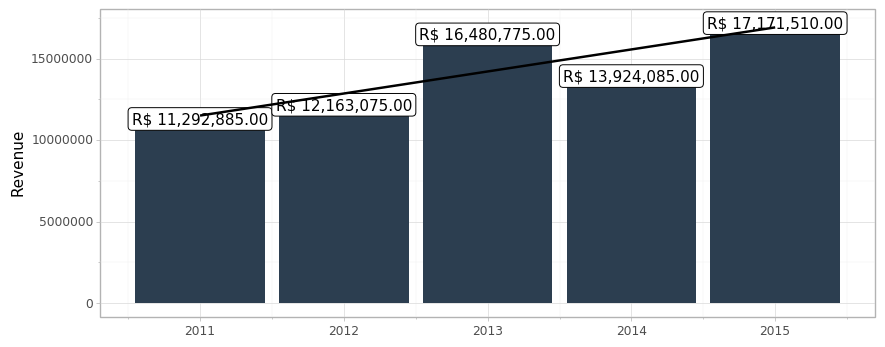

<ggplot: (8772393643025)>

In [227]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (10, 4)

(
    ggplot(sales_by_year_df, aes(x='YEAR', y='SALES')) +
    geom_col(fill="#2C3E50") +
    geom_label(aes(label = 'SALES_TEXT')) +
    geom_smooth(method="lm", se=False) +
    theme_light() +
    labs(x="", y="Revenue")
)

# Sales by Year and Category 2

In [219]:
sales_by_year_category_2_df = (
    bike_orderlines_wrangled_df
    .filter(['ORDER_DATE', 'TOTAL_PRICE', 'CATEGORY_2'])
    .assign(YEAR=lambda x: x.ORDER_DATE.dt.year)
    .groupby(['YEAR', 'CATEGORY_2'])
    .agg(SALES=('TOTAL_PRICE', 'sum'))
    .reset_index()
    .assign(SALES_TEXT=lambda x: x.SALES.map('R$ {:,.2f}'.format))
)

In [220]:
sales_by_year_category_2_df.hvplot.table()

:Table   [YEAR,CATEGORY_2,SALES,SALES_TEXT]

In [251]:
sales_by_year_category_2_df.hvplot(kind='bar', x='YEAR', y='SALES', groupby='CATEGORY_2', by='CATEGORY)

:DynamicMap   [CATEGORY_2]
   :Bars   [YEAR,SALES]   (SALES)

/home/joao/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


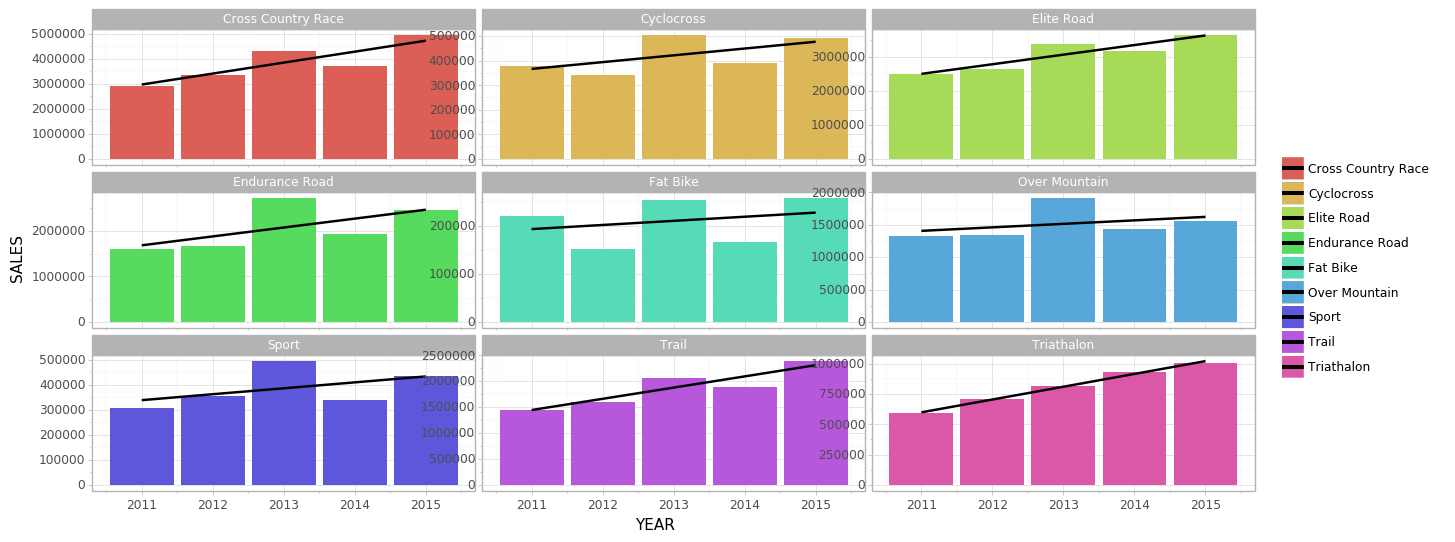

<ggplot: (8772391933617)>

In [234]:
plotnine.options.figure_size = (15, 6)

(
    ggplot(sales_by_year_category_2_df, aes('YEAR', 'SALES', fill = 'CATEGORY_2')) +
    geom_col() +
    geom_smooth(method="lm", se=False) +
    facet_wrap("CATEGORY_2", scales="free_y") +

    theme_light() +
    labs(fill="")
)